In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

from nyaggle.experiment import run_experiment

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v3_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v3_test_df.parquet')

In [3]:
train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

In [14]:
train_df

,session_id,yado_no,target,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd,TE_ken_cd,TE_lrg_cd,TE_sml_cd,TE_yado_no
0,000104bdffaaad1a1e0a9ebacf585f33,96,1,0,1,1,1,0,0,0,228.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,5,17,27,31,1725156,136135,52732,51851,1379,0,0.016339,0.025044,0.026324,0.025747,0.025022
1,000104bdffaaad1a1e0a9ebacf585f33,902,0,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,5,17,27,31,1725156,136135,52732,51851,1336,0,0.016339,0.025044,0.026324,0.025747,0.039778
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0,-1,0,1,-1,-1,0,0,144.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,179.0,547.5,58.0,5.0,2.0,2.0,5,17,27,31,1725156,136135,52732,51851,1339,0,0.016339,0.025044,0.026324,0.025747,0.047794
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,5,17,27,31,1725156,136135,52732,51851,1349,0,0.016339,0.025044,0.026324,0.025747,0.040073
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0,-1,0,1,-1,-1,0,0,176.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,141.0,979.5,128.0,14.0,10.0,10.0,5,17,27,31,1725156,136135,52732,51851,1348,0,0.016339,0.025044,0.026324,0.025747,0.040073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14434895,fffe8c99c5b332190c3d4a2d6e7c5073,9368,0,-1,0,1,-1,-1,0,0,24.0,1.0,0,1.0,-1.0,-1.0,-1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,21.0,7477.5,286.0,38.0,32.0,25.0,9,22,35,39,328406,37724,36204,31431,801,4,0.024851,0.030654,0.028250,0.027672,0.012422
14434896,fffe8c99c5b332190c3d4a2d6e7c5073,3046,0,-1,0,1,-1,-1,0,0,22.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,17.0,8132.5,315.0,44.0,36.0,26.0,9,22,35,39,328406,37724,36204,31431,785,4,0.024851,0.030654,0.028250,0.027672,0.007974
14434897,fffe8c99c5b332190c3d4a2d6e7c5073,4732,0,-1,0,1,-1,-1,0,0,33.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,17.0,8132.5,315.0,44.0,36.0,26.0,9,22,35,39,328406,37724,36204,31431,736,4,0.024851,0.030654,0.028250,0.027672,0.018739
14434898,fffe8c99c5b332190c3d4a2d6e7c5073,6214,0,-1,0,1,-1,-1,0,0,35.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,7d3db9a7acad537c322f85f7cef0beda,34f448c0371e84f8fe5a079d8d04211e,97de2b919a8ec19e656e5913804b0c84,16.0,8318.5,322.0,47.0,38.0,28.0,9,22,35,39,328406,37724,36204,31431,712,4,0.024851,0.030654,0.028250,0.027672,0.000000


### CatBoost

In [21]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
# Target Encoding した特徴量は除外
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名

# LightGBM のパラメータ
params = {
        "loss_function": 'Logloss', #'MAE', 'Logloss', 'AUC', 'MultiClass','RMSE'
        "learning_rate": 0.2, #0.05
        "iterations": 10000,
        "depth" : 10,
        "early_stopping_rounds":100,
        "random_seed":42531,
        "cat_features": cat_cols,
    }

In [22]:
train_df[features][cat_cols]

,yado_no,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd
0,96,5,17,27,31
1,902,5,17,27,31
2,12491,5,17,27,31
3,5490,5,17,27,31
4,1284,5,17,27,31
...,...,...,...,...,...
14434895,9368,9,22,35,39
14434896,3046,9,22,35,39
14434897,4732,9,22,35,39
14434898,6214,9,22,35,39


In [24]:
# 交差検証の実施
auc_scores = []  # 各foldのAUCスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # CatBoost モデルの初期化
    model = CatBoostClassifier(**params, thread_count=-1)

    # トレーニングとバリデーションデータセットの作成
    train_dataset = Pool(data=train_data[features], label=train_data[target])
    valid_dataset = Pool(data=valid_data[features], label=valid_data[target])

    # モデルの訓練
    model.fit(
        train_dataset,
        eval_set=valid_dataset,
        early_stopping_rounds=50,
        verbose=10,
        plot=False
    )

    # バリデーションデータでの予測と評価
    valid_pred = model.predict_proba(valid_data[features])[:, 1]
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # テストデータでの予測
    test_pred.append(model.predict_proba(test_df[features])[:, 1])

    # aucの計算
    auc_score = roc_auc_score(valid_data[target], valid_pred)
    auc_scores.append(auc_score)
    print(f'Fold {fold}: AUC = {auc_score}')

# 平均 AUC の計算
print(f'Mean AUC: {sum(auc_scores) / len(auc_scores)}')

0:	learn: 0.3441861	test: 0.3438101	best: 0.3438101 (0)	total: 1.48s	remaining: 4h 5m 49s
10:	learn: 0.0536986	test: 0.0537527	best: 0.0537527 (10)	total: 19.5s	remaining: 4h 54m 42s
20:	learn: 0.0526187	test: 0.0527219	best: 0.0527219 (20)	total: 38.9s	remaining: 5h 8m 10s
30:	learn: 0.0524070	test: 0.0525578	best: 0.0525578 (30)	total: 58.8s	remaining: 5h 14m 54s
40:	learn: 0.0522744	test: 0.0524795	best: 0.0524795 (40)	total: 1m 18s	remaining: 5h 18m 18s
50:	learn: 0.0521778	test: 0.0524199	best: 0.0524199 (50)	total: 1m 38s	remaining: 5h 19m 8s
60:	learn: 0.0520654	test: 0.0523614	best: 0.0523614 (60)	total: 1m 57s	remaining: 5h 19m 22s
70:	learn: 0.0519948	test: 0.0523344	best: 0.0523344 (70)	total: 2m 17s	remaining: 5h 21m 1s
80:	learn: 0.0519250	test: 0.0523113	best: 0.0523113 (80)	total: 2m 37s	remaining: 5h 20m 45s
90:	learn: 0.0518642	test: 0.0522930	best: 0.0522930 (90)	total: 2m 55s	remaining: 5h 19m 13s
100:	learn: 0.0517934	test: 0.0522655	best: 0.0522655 (100)	total: 3m 

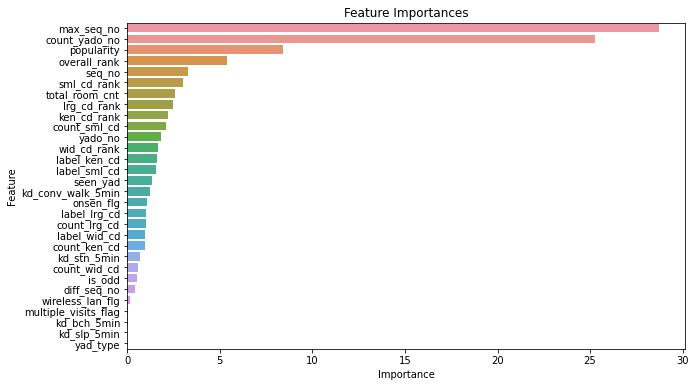

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 特徴量重要度の取得
feature_importances = model.get_feature_importance()

# 特徴量名とその重要度を DataFrame に変換
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
})

# 重要度で降順にソート
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 特徴量重要度のプロット
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### CV計算

In [27]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yado_no', 'oof_pred']].head()

,session_id,yado_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,96,0.865021
1,000104bdffaaad1a1e0a9ebacf585f33,902,0.014398
2,000104bdffaaad1a1e0a9ebacf585f33,12491,0.023965
3,000104bdffaaad1a1e0a9ebacf585f33,5490,0.009330
4,000104bdffaaad1a1e0a9ebacf585f33,1284,0.011107


In [28]:
# Use 'session_id' from train_label to order train_df
train_df_ordered = train_df.set_index('session_id').loc[train_label['session_id']].reset_index()[['session_id', 'yado_no', 'oof_pred']]
train_df_ordered.head()

,session_id,yado_no,oof_pred
0,000007603d533d30453cc45d0f3d119f,11882,0.011372
1,000007603d533d30453cc45d0f3d119f,2808,0.030487
2,000007603d533d30453cc45d0f3d119f,4101,0.019810
3,000007603d533d30453cc45d0f3d119f,5289,0.009764
4,000007603d533d30453cc45d0f3d119f,9187,0.000331


In [29]:
# train_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = train_df_ordered.sort_values(by=['session_id', 'oof_pred'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
result_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
result_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
result_df = result_df.reset_index()

result_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,000007603d533d30453cc45d0f3d119f,997,5821,1648,12837,7157,12846,11101,11134,7281,4391
1,0000ca043ed437a1472c9d1d154eb49b,2570,13717,8140,8253,13079,8677,825,3725,13682,1092
2,0000d4835cf113316fe447e2f80ba1c8,13642,918,9039,7257,7796,2957,6722,6676,9854,11031
3,0000fcda1ae1b2f431e55a7075d1f500,1341,10483,8355,9790,9438,7812,6178,11715,6723,626
4,000104bdffaaad1a1e0a9ebacf585f33,96,12491,3894,902,7749,1284,10915,11380,5490,1908


In [30]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.drop(columns=['session_id']).values

In [31]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 

In [32]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])



In [33]:
# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.37669986085311086


### 予測ファイルの作成

In [34]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[0.9188264  0.00358821 0.00702505 ... 0.00926626 0.0097082  0.00642287]
8735000


In [35]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yado_no', 'target']].head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.918826
1,00001149e9c73985425197104712478c,4545,0.003588
2,00001149e9c73985425197104712478c,9534,0.007025
3,00001149e9c73985425197104712478c,6563,0.006675
4,00001149e9c73985425197104712478c,4420,0.004396


In [36]:
# Use 'session_id' from test_session to order test_df
test_df_ordered = test_df.set_index('session_id').loc[test_session['session_id']].reset_index()[['session_id', 'yado_no', 'target']]
test_df_ordered.head()

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.918826
1,00001149e9c73985425197104712478c,4545,0.003588
2,00001149e9c73985425197104712478c,9534,0.007025
3,00001149e9c73985425197104712478c,6563,0.006675
4,00001149e9c73985425197104712478c,4420,0.004396


In [37]:
test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

,session_id,yado_no,target
0,00001149e9c73985425197104712478c,3560,0.918826
21,00001149e9c73985425197104712478c,9830,0.036784
27,00001149e9c73985425197104712478c,6766,0.017821
24,00001149e9c73985425197104712478c,11496,0.016897
10,00001149e9c73985425197104712478c,2680,0.013845
...,...,...,...
8734958,ffffe984aafd6127ce8e43e3ca40c79d,385,0.002064
8734968,ffffe984aafd6127ce8e43e3ca40c79d,9182,0.000356
8734967,ffffe984aafd6127ce8e43e3ca40c79d,9190,0.000294
8734969,ffffe984aafd6127ce8e43e3ca40c79d,9183,0.000199


In [38]:
# test_df_ordered を 'session_id' と 'oof_pred' でソート
sorted_df = test_df_ordered.sort_values(by=['session_id', 'target'], ascending=[True, False])

# 各 session_id ごとに上位10件を取得
top10_df = sorted_df.groupby('session_id').head(10)

# 新しい列 'rank' を追加して各 session_id 内での順位を表す
top10_df['rank'] = top10_df.groupby('session_id').cumcount()

# 'rank' 列と 'session_id' 列を使って pivot する
submit_df = top10_df.pivot(index='session_id', columns='rank', values='yado_no')
submit_df.columns = [f'predict_{i}' for i in range(10)]  # 列名を設定
submit_df = submit_df.reset_index()

submit_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session_id,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,00001149e9c73985425197104712478c,3560,9830,6766,11496,2680,4948,5466,11561,2040,9534
1,0000e02747d749a52b7736dfa751e258,4066,12862,143,6555,1266,11923,5055,5267,7014,11822
2,0000f17ae2628237d78d3a38b009d3be,757,9910,410,7710,11001,2267,6730,1774,13570,6721
3,000174a6f7a569b84c5575760d2e9664,12341,6991,5657,2795,277,3359,7413,10861,8645,10535
4,00017e2a527901c9c41b1acef525d016,5713,12029,13590,9623,3844,12524,6126,5372,6576,5106


In [39]:
# 欠損がないかをチェック
print(submit_df.isnull().sum(axis=1).sum())
print(submit_df.shape)

0
(174700, 11)


In [40]:
submit_df.drop(columns=['session_id']).to_csv('../submissions/CatBinary_ver1.csv', index=False)